In [1]:
import urllib2
import time
import lxml
import lxml.html

In [2]:
def getPageDoc(url):
    #headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36'}
    headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.86 Safari/537.36'}
    request = urllib2.Request(url, headers=headers)  # 发送请求
    response = urllib2.urlopen(request)  # 获得响应
    time.sleep(1)
    content = response.read()  # 获取网页内容
    doc = lxml.html.fromstring(content)  # 可能是将网页以xml格式解析
    return doc

def getAndSavePic(pic_url, file_name):
    #headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36'}
    headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.86 Safari/537.36'}
    request = urllib2.Request(url, headers=headers)  # 发送请求
    
    try:
        response = urllib2.urlopen(request)  # 获得响应
        time.sleep(0.5)
        img = response.read()
        # save image to disk
        imgFile = open(file_name,'wb')
        imgFile.write(img)
        imgFile.close()
    except Exception as t:
        raise t

### crawling images from https://www.zhidiy.com/jianzhi/page_*.html

In [3]:
def getPicURL(doc):
    '''extract picture urls from page https://www.zhidiy.com/jianzhi/page_*.html'''
    elements = doc.find_class('piclist_k')
    urls = []
    for e in elements:
        urls.append(e.getchildren()[0].xpath('a/img')[0].get('src'))
    return urls

for page_num in range(27):
    print page_num,
    page_url = 'https://www.zhidiy.com/jianzhi/page_'+str(page_num)+'.html'
    doc = getPageDoc(page_url)
    pic_urls = getPicURL(doc)
    for url in urls:
        file_name = url[url.rindex('/')+1:]
        getAndSavePic(url, file_name)
    print 'done'

### crawling images from baidu image

In [ ]:
import re
def getPicURL(doc):
    '''extract picture urls from page https://image.baidu.com/search_index?xx'''
    page = doc.text_content()
    reg =  re.compile('"thumbURL":"(.*?)"')
    urls = re.findall(reg, page)
    return urls

for page_num in range(2):
    print 'page_num', page_num,
    word = urllib2.quote('剪纸 春') # 剪纸 福 top 10pages; 剪纸 猪 top 2pages; 剪纸 春 top 2pages
    num_per_page = 60
    page_url = "https://image.baidu.com/search/flip?tn=baiduimage&ie=utf-8&word="+word+"&rn="+\
        "&pn="+str(num_per_page*page_num)+"&gsm=0&ct=&ic=0&lm=-1&width=0&height=0"
    doc = getPageDoc(page_url)
    pic_urls = getPicURL(doc)
    print '#pic', len(pic_urls),
    for pic_url in pic_urls:
        file_name = pic_url[pic_url.rindex('/')+1:]
        getAndSavePic(pic_url, './baidu_spring/'+file_name)
    print 'done'
print 'ALL DONE'

### preprocessing image: crop and resize

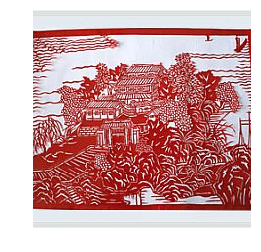

In [1]:
import matplotlib.pyplot as plt # plt 用于显示图片
%matplotlib inline
import matplotlib.image as mpimg # mpimg 用于读取图片

def plt_im(file_name):
    im_data = mpimg.imread(file_name) # img To array
    plt.imshow(im_data) # 显示图片, 可选参数cmap=['hot'|'Greys_r']
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
plt_im('./dataset/2142_1714200213_224.jpg')

In [ ]:
import os
src_dir_path = './dataset' # other dirs: '/baidu/spring/', './baidu_pig', './baidu_fu', './dataset'
dst_dir_path = './resized_dataset'
dst_height, dst_width = 224, 224
for file_name in os.listdir(src_dir_path):
    src_path = os.path.join(src_dir_path, file_name)
#     plt_im(src_path)
    src = mpimg.imread(src_path)
    shape = src.shape
    if len(src.shape)==3 and shape[0]>=dst_width and shape[1]>=dst_height:
        crop_size = min(shape[0], shape[1])
        width_start, width_end = (shape[1]-crop_size)/2, shape[1]-(shape[1]-crop_size)/2
        height_start, height_end = (shape[0]-crop_size)/2, shape[0]-(shape[0]-crop_size)/2
        dst = src[height_start:height_end, width_start:width_end, :]
        dst = scipy.misc.imresize(dst, (dst_height, dst_width))
        if dst.shape[:2]==(dst_height, dst_width):
            try:
                scipy.misc.imsave(os.path.join(dst_dir_path, file_name), dst)
            except Exception as t:
                os.remove(os.path.join(dst_dir_path, file_name))
                print src_path, t
        else:
            print dst.shape

### XDoG for sketch filtering
source from https://blog.csdn.net/qq_27879381/article/details/72718135

In [ ]:
from PIL import Image, ImageEnhance
from pylab import *
#import numpy as np
from scipy.ndimage import filters
#from skimage import io
import glob, os

in_dir = './resized'
out_dir = in_dir + '_gamma0.98'
if not os.path.exists(out_dir): os.mkdir(out_dir)

for files1 in glob.glob(in_dir + '/*'):
    filepath, filename = os.path.split(files1)

    Gamma = 0.98
    Phi = 200
    Epsilon = 0.1
    k = 2.5
    Sigma = 1.5

    im = Image.open(files1).convert('L')
    im = array(ImageEnhance.Sharpness(im).enhance(3.0))
    im2 = filters.gaussian_filter(im, Sigma)
    im3 = filters.gaussian_filter(im, Sigma* k)
    differencedIm2 = im2 - (Gamma * im3)
    (x, y) = shape(im2)
    for i in range(x):
        for j in range(y):
            if differencedIm2[i, j] < Epsilon:
                differencedIm2[i, j] = 1
            else:
                differencedIm2[i, j] = 250 + tanh(Phi * (differencedIm2[i, j]))


    gray_pic=differencedIm2.astype(np.uint8)
    final_img = Image.fromarray( gray_pic)
    final_img.save(os.path.join(out_dir, filename))
